分散、平均、回数の追加

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
import matplotlib.pyplot as plt
import pickle

['ip_count', 'ip_app_nextClick', 'cumcount_ip_by_os', 'ip_app_os_count', 'os_device_count', 'ip_by_app_countuniq', 'ip_by_device_countuniq', 'ip_app_by_os_countuniq', 'ip_os_nextClick', 'ip_app_count', 'app_by_channel_countuniq', 'channel', 'ip_device_count', 'ip_nextClick', 'ip_channel_nextClick', 'os_app_channel_count', 'ip_hour_count', 'ip_device_os_by_app_countuniq', 'ip_app_device_os_channel_nextClick', 'ip_os_device_nextClick', 'app_channel_count', 'ip_os_device_app_nextClick', 'ip_by_channel_countuniq', 'ip_by_hour_countuniq', 'device', 'app', 'os', 'cumcount_ip_dev_os_by_app', 'hour']

In [2]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def do_next_Click(df,agg_suffix='nextClick', agg_type='float32'):
    with timer("Adding next click times"):
    
        print(f">> \nExtracting {agg_suffix} time calculation features...\n")

        GROUP_BY_NEXT_CLICKS = [

        # V1
        {'groupby': ['ip']},
        {'groupby': ['ip', 'app']},
        {'groupby': ['ip', 'channel']},
        {'groupby': ['ip', 'os']},

        # V3
        {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
        {'groupby': ['ip', 'os', 'device']},
        {'groupby': ['ip', 'os', 'device', 'app']},
    #     {'groupby': ['device']},
    #     {'groupby': ['device', 'channel']},     
#         {'groupby': ['app', 'device', 'channel']},
#         {'groupby': ['device', 'hour']}
        ]

        # Calculate the time to next click for each group
        for spec in GROUP_BY_NEXT_CLICKS:

           # Name of new feature
            new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    

            # Unique list of features to select
            all_features = spec['groupby'] + ['click_time']

            # Run calculation
            print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
            df[new_feature] = (df[all_features].groupby(spec[
                'groupby']).click_time.shift(-1) - df.click_time).dt.seconds.astype(agg_type)

#             predictors.append(new_feature)
            gc.collect()
        return (df)
    
def do_prev_Click( df,agg_suffix='prevClick', agg_type='float32'):

    print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
    
    # V1
    # {'groupby': ['ip']},
    # {'groupby': ['ip', 'app']},
#     {'groupby': ['ip', 'channel']},
#     {'groupby': ['ip', 'os']},
    
    # V3
    #{'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    #{'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        df[new_feature] = (df.click_time - df[all_features].groupby(spec[
                'groupby']).click_time.shift(+1) ).dt.seconds.astype(agg_type)
        
#         predictors.append(new_feature)
        gc.collect()
    return (df)    
    
def df_add_counts(df, cols):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(axis=0) + 1),
                                     return_inverse=True, return_counts=True)
    df["_".join(cols)+'_count'] = counts[unqtags]
    gc.collect()
    
def make_count_features(df):
    with timer("add count features"):
        df['click_time']= pd.to_datetime(df['click_time'])
        dt= df['click_time'].dt
#         df['day'] = dt.day.astype('uint8')
        df['hour'] = dt.hour.astype('uint8')
#         df['minute'] = dt.minute.astype('uint8')
#         df['second'] = dt.second.astype('uint8')#secondを追加

        del(dt)
    
#         df_add_counts(df, ['ip','channel','hour'])
#         df_add_counts(df, ['ip','day'])
#         df_add_counts(df, ['ip','day','hour','channel'])

        
        df_add_counts(df, ['ip'])
# #         df_add_counts(df, ['ip','day','hour','minute'])
        df_add_counts(df, ['os','device'])
        df_add_counts(df, ['os','app','channel'])
        
        df_add_counts(df, ['ip', 'hour'])
        df_add_counts(df, ['ip', 'app'])
        df_add_counts(df, ['ip', 'app', 'os'])
        df_add_counts(df, ['ip', 'device'])
        df_add_counts(df, ['app', 'channel'])

def do_countuniq( df, group_cols, counted, agg_type='uint32', show_max=False, show_agg=True ):
    with timer("add countuniq feature"):
        agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
        if show_agg:
            print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
        gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
        df = df.merge(gp, on=group_cols, how='left')
        del gp
        if show_max:
            print( agg_name + " max value = ", df[agg_name].max() )
        df[agg_name] = df[agg_name].astype(agg_type)
    #     predictors.append(agg_name)
    #     print('predictors',predictors)
        gc.collect()
        return( df )

def make_countuniq_features(df):
    with timer("add countuniq features"):
        df = do_countuniq( df, ['ip'], 'channel' ); gc.collect()
        df = do_countuniq( df, ['ip', 'device', 'os'], 'app'); gc.collect()
        df = do_countuniq( df, ['ip'], 'hour' ); gc.collect()
        df = do_countuniq( df, ['ip'], 'app'); gc.collect()
        df = do_countuniq( df, ['ip', 'app'], 'os'); gc.collect()
        df = do_countuniq( df, ['ip'], 'device'); gc.collect()
        df = do_countuniq( df, ['app'], 'channel'); gc.collect()
        return(df)

def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint16', show_max=False, show_agg=True ):
    with timer("add countuniq feature"):
        if show_agg:
            print( "Cumulative count by ", group_cols , '...' )
        gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
        df[agg_name]=gp.values
        del gp
        if show_max:
            print( agg_name + " max value = ", df[agg_name].max() )
        df[agg_name] = df[agg_name].astype(agg_type)
        gc.collect()
        return( df )

# def make_next_click_feature(df):
#     with timer("Adding next click times"):
#         D= 2**26
#         df['category'] = (df['ip'].astype(str) + "_" + df['app'].astype(str) + "_" + df['device'].astype(str) \
#                          + "_" + df['os'].astype(str)).apply(hash) % D
#         click_buffer= np.full(D, 3000000000, dtype=np.uint32)
#         df['epochtime']= df['click_time'].astype(np.int64) // 10 ** 9
#         next_clicks= []
#         for category, time in zip(reversed(df['category'].values), reversed(df['epochtime'].values)):
#             next_clicks.append(click_buffer[category]-time)
#             click_buffer[category]= time
#         del(click_buffer)
#         df['next_click']= list(reversed(next_clicks))
#         gc.collect()
        
path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

columns = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [3]:
with timer("load training data"):
    train_df = pd.read_csv(path+"train.csv", usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], dtype=dtypes)

with timer("load test data"):
    testsup_df = pd.read_csv(path+"test_supplement.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load training data] done in 103 s
[load test data] done in 34 s


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 7 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed    uint8
dtypes: object(1), uint16(4), uint32(1), uint8(1)
memory usage: 3.6+ GB


In [6]:
num_train = train_df.shape[0]

y = train_df.is_attributed.values
gc.collect()

# sub = pd.DataFrame()
# sub['click_id'] = test_df.click_id.values

common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df[common_column],testsup_df[common_column]])

del train_df, testsup_df
gc.collect()

118

In [8]:
make_count_features(concat_df)

[add count features] done in 993 s


In [9]:
concat_df = make_countuniq_features(concat_df)

gc.collect()


Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  hour  by  ['ip'] ... and saved in ip_by_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq
[add countuniq features] done in 2264 s


41

In [11]:
concat_df = do_cumcount(concat_df, ['ip', 'device', 'os'], 'app', 'cumcount_ip_dev_os_by_app', show_max=True )
# concat_df = do_cumcount(concat_df, ['ip'], 'app', 'cumcount_ip_by_app', show_max=True )
concat_df = do_cumcount(concat_df, ['ip'], 'os', 'cumcount_ip_by_os', show_max=True )
gc.collect()

Cumulative count by  ['ip', 'device', 'os'] ...
cumcount_ip_dev_os_by_app max value =  342409
[add countuniq feature] done in 141 s
Cumulative count by  ['ip'] ...
cumcount_ip_by_os max value =  1742880
[add countuniq feature] done in 70 s


0

In [14]:
concat_df.head(100000)

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,app_channel_count,ip_by_channel_countuniq,ip_device_os_by_app_countuniq,ip_by_hour_countuniq,ip_by_app_countuniq,ip_app_by_os_countuniq,ip_by_device_countuniq,app_by_channel_countuniq,cumcount_ip_dev_os_by_app,cumcount_ip_by_os
0,83230,3,1,13,379,2017-11-06 14:32:21,14,32794,49858614,282708,...,1314929,141,51,24,90,48,30,50,0,0
1,17357,3,1,19,379,2017-11-06 14:33:34,14,30826,56240944,337657,...,1314929,137,48,24,81,51,29,50,0,0
2,35810,3,1,13,379,2017-11-06 14:34:12,14,13162,49858614,282708,...,1314929,139,42,24,73,52,19,50,0,0
3,45745,14,1,13,478,2017-11-06 14:34:52,14,220500,49858614,5659,...,24090,152,63,24,164,71,122,40,0,0
4,161007,3,1,13,379,2017-11-06 14:35:08,14,1171,49858614,282708,...,1314929,94,28,22,38,21,5,50,0,0
5,18787,3,1,16,379,2017-11-06 14:36:26,14,4639,3846516,20906,...,1314929,111,20,24,50,31,2,50,0,0
6,103022,3,1,23,379,2017-11-06 14:37:44,14,7175,2476947,8565,...,1314929,109,4,24,46,39,13,50,0,0
7,114221,3,1,19,379,2017-11-06 14:37:59,14,3301,56240944,337657,...,1314929,94,30,23,41,30,5,50,0,0
8,165970,3,1,13,379,2017-11-06 14:38:10,14,2014,49858614,282708,...,1314929,93,22,23,33,32,6,50,0,0
9,74544,64,1,22,459,2017-11-06 14:38:23,14,4442,9563728,63180,...,1895374,106,20,24,50,17,8,3,0,0


In [16]:
concat_df = do_next_Click(concat_df)
gc.collect()

>> 
Extracting nextClick time calculation features...

>> Grouping by ['ip'], and saving time to nextClick in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to nextClick in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to nextClick in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to nextClick in: ip_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to nextClick in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to nextClick in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to nextClick in: ip_os_device_app_nextClick
[Adding next click times] done in 11198 s


0

In [17]:
train_df = concat_df.iloc[:num_train]
testsup_df = concat_df.iloc[num_train:]

del concat_df
gc.collect()

35

In [35]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
gc.collect()

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       432|
|                      Out|       648|
|                       ax|        56|
|         bagging_fraction|        24|
|             bagging_freq|        28|
| bin_construct_sample_cnt|        28|
|                  booster|        56|
|              categorical|       104|
|                  columns|       120|
|           contextmanager|       136|
|            df_add_counts|       136|
|             do_countuniq|       136|
|              do_cumcount|       136|
|            do_next_Click|       136|
|            do_prev_Click|       136|
|                   dtypes|       368|
|    early_stopping_rounds|        28|
|            evals_results|       240|
|                     exit|        56|
|                        f|       176|
|         feature_fraction|        24|
|                       gc|        80|
|              get_ipython|        64|
|                join_col

0

In [14]:
concat_df.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'hour',
       'ip_count', 'os_device_count', 'os_app_channel_count', 'ip_hour_count',
       'ip_app_count', 'ip_app_os_count', 'ip_device_count',
       'app_channel_count', 'ip_by_channel_countuniq',
       'ip_device_os_by_app_countuniq', 'ip_by_hour_countuniq',
       'ip_by_app_countuniq', 'ip_app_by_os_countuniq',
       'ip_by_device_countuniq', 'app_by_channel_countuniq',
       'cumcount_ip_dev_os_by_app', 'cumcount_ip_by_os', 'ip_nextClick',
       'ip_app_nextClick', 'ip_channel_nextClick', 'ip_os_nextClick',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_nextClick',
       'ip_os_device_app_nextClick', 'ip_os_device_app_prevClick',
       'next_click_counts'],
      dtype='object')

In [18]:
# del concat_df['app_by_channel_countuniq']
del gp
gc.collect()

7

In [14]:
# データ保存
with open('train_add_features_v3.csv.pkl','wb') as f:
  pickle.dump(train_df,f,protocol=4)

with open('testsup_add_features_v3.csv.pkl','wb') as f:
  pickle.dump(testsup_df,f,protocol=4)

# with open('y.csv.pkl','wb') as f:
#   pickle.dump(y, f, protocol=4)

In [20]:
concat_df.tail()

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,cumcount_ip_by_os,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick,next_click_counts
242441390,49553,13,1,16,400,2017-11-10 16:00:00,16,32647,3846516,15074,...,32646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336.0,33
242441391,63438,2,1,19,237,2017-11-10 16:00:00,16,11477,56240944,843006,...,11476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657.0,223
242441392,111786,18,1,22,121,2017-11-10 16:00:00,16,6131,9563728,170008,...,6130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13682.0,7
242441393,56730,1,1,13,153,2017-11-10 16:00:00,16,4702,49858614,279609,...,4701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,59
242441394,25648,14,1,19,379,2017-11-10 16:00:00,16,64547,56240944,606447,...,64546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1810.0,234


In [19]:
# #データ読みこみ
# with open('train_add_features.csv.pkl','rb') as f:
#   train_df = pickle.load(f)

# with open('testsup_add_features_v2.csv.pkl','rb') as f:
#   testsup_df = pickle.load(f)

with open('y.csv.pkl','rb') as f:
  y = pickle.load(f)

In [4]:
num_train = train_df.shape[0]

# sub = pd.DataFrame()
# sub['click_id'] = test_df.click_id.values

# common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df,testsup_df])

del train_df, testsup_df
gc.collect()

150

In [5]:
join_cols = ['ip', 'app', 'device', 'os']

with timer("add feature"):
    gp = concat_df.groupby(['ip', 'app', 'device', 'os'])['channel'].count().reset_index().rename(columns={'channel':'next_click_counts'})
    concat_df = concat_df.merge(gp, how='left', on=join_cols)
    del gp
    gc.collect()

[add feature] done in 420 s


In [6]:
with timer("add feature"):
    gp = concat_df.groupby(['ip', 'app', 'device', 'os'])['ip_os_device_app_nextClick'].var().reset_index().rename(columns={'ip_os_device_app_nextClick':'next_click_var'})
    concat_df = concat_df.merge(gp, how='left', on=join_cols)
    del gp
    gc.collect()

[add feature] done in 508 s


In [7]:
with timer("add feature"):
    gp = concat_df.groupby(['ip', 'app', 'device', 'os'])['ip_os_device_app_nextClick'].mean().reset_index().rename(columns={'ip_os_device_app_nextClick':'next_click_mean'})
    concat_df = concat_df.merge(gp, how='left', on=join_cols)
    del gp
    gc.collect()

[add feature] done in 515 s


In [10]:
concat_df.head()

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick,next_click_counts,next_click_var,next_click_mean
0,83230,3,1,13,379,2017-11-06 14:32:21,14,32794,49858614,282708,...,5340.0,5444.0,5307.0,8889.0,5307.0,5340.0,NaN,1598,4.915745e+06,273.512848
1,17357,3,1,19,379,2017-11-06 14:33:34,14,30826,56240944,337657,...,5177.0,5177.0,5239.0,36039.0,5239.0,5547.0,NaN,1596,5.090379e+05,219.896545
2,35810,3,1,13,379,2017-11-06 14:34:12,14,13162,49858614,282708,...,5175.0,6005.0,5205.0,38677.0,5205.0,5925.0,NaN,460,4.424982e+06,762.302856
3,45745,14,1,13,478,2017-11-06 14:34:52,14,220500,49858614,5659,...,5110.0,5137.0,5108.0,13882.0,5108.0,5110.0,NaN,2454,7.187990e+04,142.955978
4,161007,3,1,13,379,2017-11-06 14:35:08,14,1171,49858614,282708,...,6431.0,9423.0,27338.0,33841.0,27338.0,33756.0,NaN,80,4.224820e+07,2208.658203


In [8]:
concat_df = do_prev_Click(concat_df)
gc.collect()

>> 
Extracting prevClick time calculation features...

>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to prevClick in: ip_os_device_app_prevClick


NameError: name 'predictors' is not defined

In [10]:
concat_df.tail()

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,cumcount_ip_dev_os_by_app,cumcount_ip_by_os,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick
242441390,49553,13,1,16,400,2017-11-10 16:00:00,16,32647,3846516,15074,...,794,32646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336.0
242441391,63438,2,1,19,237,2017-11-10 16:00:00,16,11477,56240944,843006,...,2190,11476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657.0
242441392,111786,18,1,22,121,2017-11-10 16:00:00,16,6131,9563728,170008,...,160,6130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13682.0
242441393,56730,1,1,13,153,2017-11-10 16:00:00,16,4702,49858614,279609,...,1259,4701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0
242441394,25648,14,1,19,379,2017-11-10 16:00:00,16,64547,56240944,606447,...,16042,64546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1810.0


In [20]:
# train_df = concat_df.iloc[:num_train]
# testsup_df = concat_df.iloc[num_train:]

# del concat_df
gc.collect()

657

In [16]:
train_df.shape[0]

184903890

In [21]:
gc.collect()
x_train, x_val, y_train, y_val = train_test_split(train_df, y, train_size=0.9, random_state=0)

del train_df, y
gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


14

In [22]:
evals_results = {}
# num_boost_round = 250
# early_stopping_rounds = 30
num_boost_round = 10000
early_stopping_rounds = 50

# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'subsample_for_bin': 200000,  # Number of samples for constructing bin
#     'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
#     'reg_alpha': 0,  # L1 regularization term on weights
#     'reg_lambda': 0,  # L2 regularization term on weights
#     'nthread': 8,
#     'verbose': 0,
#     'metric':'auc',     
 
#     'learning_rate': 0.15,
#     'num_leaves': 7,  # 2^max_depth - 1
#     'max_depth': 3,  # -1 means no limit
#     'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
#     'max_bin': 100,  # Number of bucketed bin for feature values
#     'subsample': 0.7,  # Subsample ratio of the training instance.
#     'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
#     'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
#     'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
#     'scale_pos_weight':99
# }

# matsuda Hyperparameters
min_data_in_leaf = 100
# min_data_in_leaf = 50
max_bin = 127
bagging_fraction = 0.7
bagging_freq = 1 
feature_fraction = 0.9
bin_construct_sample_cnt = 100000
min_hessian = 0 
scale_pos_weight = 200
max_depth = -1

lgb_params = {
   'boosting_type': 'gbdt',
   'objective': 'binary',
   'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
   'nthread': 24,
   'verbose': 0,
   'metric': 'auc',
   'learning_rate': 0.05,
#    'learning_rate': 0.1,
   'max_depth': max_depth,  # -1 means no limit
   'num_leaves': 31,  # 2^max_depth - 1
   'min_child_samples': min_data_in_leaf,  # Minimum number of data need in a child(min_data_in_leaf)
   'max_bin': max_bin,  # Number of bucketed bin for feature values
   'bin_construct_sample_cnt': bin_construct_sample_cnt,
   # 'subsample_for_bin': 20000,  # Number of samples for constructing bin
   'bagging_fraction': bagging_fraction,  # subsample
   'bagging_freq': bagging_freq,  # subsample_freq
   'feature_fraction': feature_fraction,  # colsample_bytree
   'min_sum_hessian_in_leaf': min_hessian,  # min_child_weight
   'scale_pos_weight': scale_pos_weight
}


# metrics = 'auc'
# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': metrics,
#     'learning_rate': .1,
#     'num_leaves': 7,
#     'max_depth': 4,
#     'min_child_samples': 100,
#     'max_bin': 100,
#     'subsample': 0.7,
#     'subsample_freq': 1,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 0,
#     'min_split_gain': 0,
#     'nthread': 4,
#     'verbose': 1,
#     'scale_pos_weight': 99.7
#     #'scale_pos_weight': 400
# }

In [23]:
# del testsup_df
gc.collect()

0

In [24]:
x_train.columns
# # del x_train['click_time']
# del x_val['click_time']
# del x_train['ip']
# del x_val['ip']
# del x_train['app_by_channel_countuniq']
# del x_val['app_by_channel_countuniq']
# gc.collect()

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'hour',
       'ip_count', 'os_device_count', 'os_app_channel_count', 'ip_hour_count',
       'ip_app_count', 'ip_app_os_count', 'ip_device_count',
       'app_channel_count', 'ip_by_channel_countuniq',
       'ip_device_os_by_app_countuniq', 'ip_by_hour_countuniq',
       'ip_by_app_countuniq', 'ip_app_by_os_countuniq',
       'ip_by_device_countuniq', 'app_by_channel_countuniq',
       'cumcount_ip_dev_os_by_app', 'cumcount_ip_by_os', 'ip_nextClick',
       'ip_app_nextClick', 'ip_channel_nextClick', 'ip_os_nextClick',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_nextClick',
       'ip_os_device_app_nextClick', 'ip_os_device_app_prevClick',
       'next_click_counts', 'next_click_var', 'next_click_mean'],
      dtype='object')

In [26]:
x_train[(x_train.ip == 9) & (x_train.app==8) & (x_train.device==1) & (x_train.os==19)]

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick,next_click_counts,next_click_var,next_click_mean
163260993,9,8,1,19,145,2017-11-09 09:26:15,9,5414,56240944,1104136,...,282.0,282.0,0.0,282.0,0.0,282.0,1.0,29,109919240.0,4997.321289
6250994,9,8,1,19,145,2017-11-06 22:32:37,22,5414,56240944,1104136,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29,109919240.0,4997.321289
6250424,9,8,1,19,145,2017-11-06 22:32:36,22,5414,56240944,1104136,...,1.0,1.0,1.0,1.0,1.0,1.0,12.0,29,109919240.0,4997.321289
146432984,9,8,1,19,145,2017-11-09 04:26:39,4,5414,56240944,1104136,...,1075.0,1075.0,1.0,1075.0,1.0,1075.0,2176.0,29,109919240.0,4997.321289
6246585,9,8,1,19,145,2017-11-06 22:32:24,22,5414,56240944,1104136,...,12.0,12.0,0.0,12.0,0.0,12.0,1.0,29,109919240.0,4997.321289
147682077,9,8,1,19,145,2017-11-09 04:44:34,4,5414,56240944,1104136,...,3695.0,3695.0,2.0,15434.0,2.0,15434.0,1075.0,29,109919240.0,4997.321289
165330659,9,8,1,19,145,2017-11-09 10:06:43,10,5414,56240944,1104136,...,2156.0,9188.0,1.0,22624.0,1.0,2156.0,0.0,29,109919240.0,4997.321289
163495880,9,8,1,19,145,2017-11-09 09:30:59,9,5414,56240944,1104136,...,844.0,844.0,0.0,844.0,0.0,844.0,2.0,29,109919240.0,4997.321289
163494322,9,8,1,19,145,2017-11-09 09:30:57,9,5414,56240944,1104136,...,2.0,2.0,2.0,2.0,2.0,2.0,282.0,29,109919240.0,4997.321289
164181644,9,8,1,19,145,2017-11-09 09:45:03,9,5414,56240944,1104136,...,0.0,0.0,0.0,0.0,0.0,0.0,844.0,29,109919240.0,4997.321289


In [27]:
target = "is_attributed"
categorical = ['app','os','channel','hour','device']
predictors = list(set(x_train.columns)-set([target])-set(['click_time','ip','app_by_channel_countuniq']))
print(predictors)

print("preparing validation datasets")

xgtrain = lgb.Dataset(x_train[predictors].values,
                      label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_train
del y_train
gc.collect()

xgvalid = lgb.Dataset(x_val[predictors].values,
                      label=y_val,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_val
del y_val
gc.collect()

['ip_by_app_countuniq', 'ip_app_by_os_countuniq', 'app_channel_count', 'ip_app_os_count', 'ip_by_device_countuniq', 'ip_by_hour_countuniq', 'ip_app_nextClick', 'channel', 'next_click_var', 'ip_app_device_os_channel_nextClick', 'ip_by_channel_countuniq', 'ip_hour_count', 'ip_os_device_app_nextClick', 'ip_os_nextClick', 'hour', 'ip_count', 'app', 'cumcount_ip_dev_os_by_app', 'ip_os_device_nextClick', 'ip_channel_nextClick', 'ip_nextClick', 'next_click_counts', 'os_app_channel_count', 'cumcount_ip_by_os', 'ip_device_os_by_app_countuniq', 'next_click_mean', 'os_device_count', 'ip_app_count', 'ip_os_device_app_prevClick', 'ip_device_count', 'os', 'device']
preparing validation datasets


15

In [28]:
# gc.collect()
# del booster
with timer("Learning"):
    booster = lgb.train(
         lgb_params, 
         xgtrain,
         valid_sets=[xgvalid],
         valid_names=['valid'],
         evals_result=evals_results, 
         num_boost_round=num_boost_round,
         early_stopping_rounds=early_stopping_rounds,
         verbose_eval=1
    )

    del xgvalid
    del xgtrain
    gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid's auc: 0.96926
Training until validation scores don't improve for 50 rounds.
[2]	valid's auc: 0.97004
[3]	valid's auc: 0.971535
[4]	valid's auc: 0.971907
[5]	valid's auc: 0.971862
[6]	valid's auc: 0.97284
[7]	valid's auc: 0.973959
[8]	valid's auc: 0.974225
[9]	valid's auc: 0.974404
[10]	valid's auc: 0.97443
[11]	valid's auc: 0.974695
[12]	valid's auc: 0.974779
[13]	valid's auc: 0.974913
[14]	valid's auc: 0.974868
[15]	valid's auc: 0.975192
[16]	valid's auc: 0.975219
[17]	valid's auc: 0.975252
[18]	valid's auc: 0.975305
[19]	valid's auc: 0.975483
[20]	valid's auc: 0.975694
[21]	valid's auc: 0.976041
[22]	valid's auc: 0.976202
[23]	valid's auc: 0.976473
[24]	valid's auc: 0.976638
[25]	valid's auc: 0.9768
[26]	valid's auc: 0.976877
[27]	valid's auc: 0.977363
[28]	valid's auc: 0.977457
[29]	valid's auc: 0.977704
[30]	valid's auc: 0.97785
[31]	valid's auc: 0.977981
[32]	valid's auc: 0.978064
[33]	valid's auc: 0.978143
[34]	valid's auc: 0.978276
[35]	valid's auc: 0.978389
[36]	vali

[297]	valid's auc: 0.984902
[298]	valid's auc: 0.984906
[299]	valid's auc: 0.984909
[300]	valid's auc: 0.984911
[301]	valid's auc: 0.984911
[302]	valid's auc: 0.98491
[303]	valid's auc: 0.984911
[304]	valid's auc: 0.984911
[305]	valid's auc: 0.984913
[306]	valid's auc: 0.984915
[307]	valid's auc: 0.984914
[308]	valid's auc: 0.984916
[309]	valid's auc: 0.984919
[310]	valid's auc: 0.984922
[311]	valid's auc: 0.984921
[312]	valid's auc: 0.984924
[313]	valid's auc: 0.984924
[314]	valid's auc: 0.984925
[315]	valid's auc: 0.984925
[316]	valid's auc: 0.984924
[317]	valid's auc: 0.984925
[318]	valid's auc: 0.984926
[319]	valid's auc: 0.984932
[320]	valid's auc: 0.984933
[321]	valid's auc: 0.984937
[322]	valid's auc: 0.98494
[323]	valid's auc: 0.984941
[324]	valid's auc: 0.984942
[325]	valid's auc: 0.984943
[326]	valid's auc: 0.984942
[327]	valid's auc: 0.984945
[328]	valid's auc: 0.984945
[329]	valid's auc: 0.984948
[330]	valid's auc: 0.984948
[331]	valid's auc: 0.984949
[332]	valid's auc: 0.9

[591]	valid's auc: 0.985107
[592]	valid's auc: 0.985107
[593]	valid's auc: 0.985107
[594]	valid's auc: 0.985108
[595]	valid's auc: 0.985108
[596]	valid's auc: 0.985108
[597]	valid's auc: 0.985108
[598]	valid's auc: 0.985109
[599]	valid's auc: 0.985113
[600]	valid's auc: 0.985113
[601]	valid's auc: 0.985113
[602]	valid's auc: 0.985116
[603]	valid's auc: 0.985116
[604]	valid's auc: 0.985116
[605]	valid's auc: 0.985116
[606]	valid's auc: 0.985116
[607]	valid's auc: 0.985115
[608]	valid's auc: 0.985114
[609]	valid's auc: 0.985113
[610]	valid's auc: 0.985113
[611]	valid's auc: 0.985112
[612]	valid's auc: 0.985113
[613]	valid's auc: 0.985113
[614]	valid's auc: 0.985111
[615]	valid's auc: 0.98511
[616]	valid's auc: 0.985109
[617]	valid's auc: 0.985109
[618]	valid's auc: 0.985107
[619]	valid's auc: 0.985108
[620]	valid's auc: 0.985108
[621]	valid's auc: 0.985108
[622]	valid's auc: 0.985107
[623]	valid's auc: 0.985107
[624]	valid's auc: 0.985108
[625]	valid's auc: 0.98511
[626]	valid's auc: 0.9

[886]	valid's auc: 0.985152
[887]	valid's auc: 0.985152
[888]	valid's auc: 0.985151
[889]	valid's auc: 0.985152
[890]	valid's auc: 0.985151
[891]	valid's auc: 0.985152
[892]	valid's auc: 0.985152
[893]	valid's auc: 0.985151
[894]	valid's auc: 0.985152
[895]	valid's auc: 0.985151
[896]	valid's auc: 0.98515
[897]	valid's auc: 0.98515
[898]	valid's auc: 0.98515
[899]	valid's auc: 0.98515
[900]	valid's auc: 0.985149
[901]	valid's auc: 0.985149
[902]	valid's auc: 0.985149
[903]	valid's auc: 0.985149
[904]	valid's auc: 0.985149
[905]	valid's auc: 0.985148
[906]	valid's auc: 0.985148
[907]	valid's auc: 0.985148
[908]	valid's auc: 0.985148
[909]	valid's auc: 0.985149
Early stopping, best iteration is:
[859]	valid's auc: 0.985154
[Learning] done in 6308 s


In [29]:
n_estimators = booster.best_iteration
metrics = 'auc'

print('\nModel Info:')
print('n_estimators:', n_estimators)
print(metrics+':', evals_results['valid'][metrics][n_estimators-1])


Model Info:
n_estimators: 859
auc: 0.9851540006403029


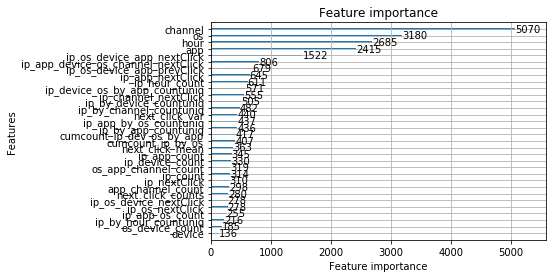

In [30]:
ax = lgb.plot_importance(booster, max_num_features=100)
plt.show()

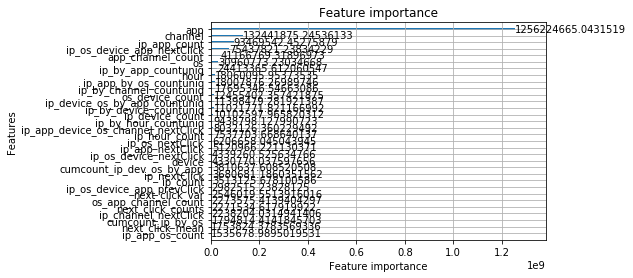

In [31]:
ax = lgb.plot_importance(booster, importance_type='gain')
plt.show()

In [32]:
plt.savefig('0507-1-2imp.png', dpi=600, bbox_inches='tight')

In [33]:
gc.collect()

6865

In [34]:
with timer("load test data"):
    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load test data] done in 15 s


In [14]:
with open('testsup_add_features_v2.csv.pkl','rb') as f:
  testsup_df = pickle.load(f)

In [36]:
test_df['click_time']= pd.to_datetime(test_df['click_time'])
testsup_df['click_time']= pd.to_datetime(testsup_df['click_time'])

In [1]:
# preditions=booster.predict(test_df[predictors].values)

gc.collect()

print("Predicting the submission data...")

testsup_df['is_attributed'] = booster.predict(testsup_df[predictors], num_iteration=booster.best_iteration)

print('projecting prediction onto test')

join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

NameError: name 'gc' is not defined

In [ ]:
test_df = test_df.merge(testsup_df[all_cols], how='left', on=join_cols)

test_df = test_df.drop_duplicates(subset=['click_id'])

In [ ]:
test_df.head()

In [ ]:
test_df.count()

In [20]:
print("Writing the submission data into a csv file...")

test_df[['click_id', 'is_attributed']].to_csv('0507-1-2.csv', index=False)

print("All done...")

Writing the submission data into a csv file...
All done...
